## Diversity Sampling of Wikipedia Articles

This notebook provides a demo of the Coreset sampler, applied to text embeddings. 
The coreset algorithm iteratively samples the furthest texts to all the previously sampled texts, ensuring diversity.




**Notes**: We recommend running it on GPU. If you don't have access to a GPU, subsampling the data may be necessary



In [3]:
cd ../src

/workspace/diversity_sampling/src


In [4]:
# TODO : Package

## Initialization

### Imports

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 1000)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

In [6]:
import torch
torch.cuda.is_available()  # Code is faster on GPU !

True

In [7]:
from coreset import CoresetSampler
from plot import plot_dbscan_results, plot_coreset_results

### Retrieve data

The dataset is a preprocessed subset from [here](https://www.kaggle.com/datasets/narek1110/wikipedia-22-12-en-embeddings-all-minilm-l6-v2). 

- **df.parquet** : contains articles & associated metadata
    - `id`: article id
    - `title`: Title of the article
    - `text`: First paragraph of the article.
    - `url`: Url of the article
    - `domain`: Predicted domain by a [this 10-class](https://huggingface.co/jonaskoenig/topic_classification_04) classifier.
    - `bertopic_class`: Predict class by [BERTopic](https://huggingface.co/MaartenGr/BERTopic_Wikipedia)
- **embeds.npy** : Embeddings assoaited to the `text` column, computed using [all-MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)

In [8]:
df = pd.read_parquet('../input/df_2.parquet')
print(f"Retrieved {len(df)} articles")

Retrieved 486826 articles


In [10]:
embeds = np.load('../input/embeds.npy')
print(f"Embedding shape: {embeds.shape}")

Embedding shape: (486826, 384)


### Coreset Sampler

The class `CoresetSampler` defined in `coreset.py` does all the heavy lifting !

I also define some parameters:
- `EPS`, `MIN_SAMPLES` are DBScan initialization parameters that work well for the provided data. 
- `N_SAMPLES` is the number of points we want to sample with coreset.

In [11]:
EPS = 0.85  # Higher eps = bigger clusters
MIN_SAMPLES = 100
N_SAMPLES = 1000

In [12]:
coreset = CoresetSampler(
    n_samples=N_SAMPLES,
    initialization="dbscan",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=False,
    verbose=1,
)

### DBScan Initialization

We run DBScan clustering and analyze the results.

It takes about 1 minute to run DBScan on our data, provided that you have a GPU.

In [14]:
%%time
init_ids = coreset.initialize(embeds)

Using cuml gpu-accelerated algorithms
Initializing with DBScan
[W] [17:09:03.703062] Batch size limited by the chosen integer type (4 bytes). 10892 -> 4411. Using the larger integer type might result in better performance
Initialize with 36 points
CPU times: user 1min 12s, sys: 947 ms, total: 1min 13s
Wall time: 1min 13s


In [15]:
y = coreset.dbscan_y
counts = np.bincount(y + 1)

In [16]:
print('Number of clusters :', len(counts) - 1)
print('Number of non-clustered prompts :', counts[0])

Number of clusters : 36
Number of non-clustered prompts : 460123


In [17]:
biggest = np.argsort(counts[1:])[::-1] # [:10]
sizes = np.sort(counts[1:])[::-1]
print('Biggest clusters :\t', list(biggest[:10]))
print('Associated sizes :\t', list(sizes[:10]))

Biggest clusters :	 [0, 4, 10, 28, 17, 18, 5, 6, 11, 15]
Associated sizes :	 [11717, 2601, 1610, 941, 837, 734, 681, 557, 503, 458]


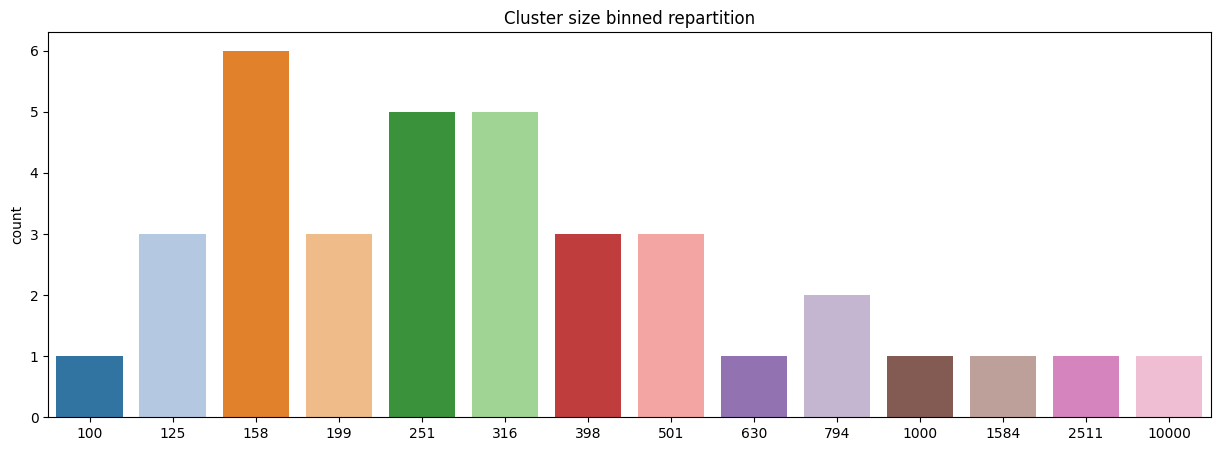

In [18]:
plt.figure(figsize=(15, 5))
sns.countplot(x=np.round(np.log10(np.clip(counts[1:], 0, 10000)), 1))
ticks, labels = plt.xticks()
labels = [float(l.get_text()) for l in labels]
plt.xticks(ticks, (10 ** np.array(labels)).astype(int))
plt.title('Cluster size binned repartition')
plt.show()

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


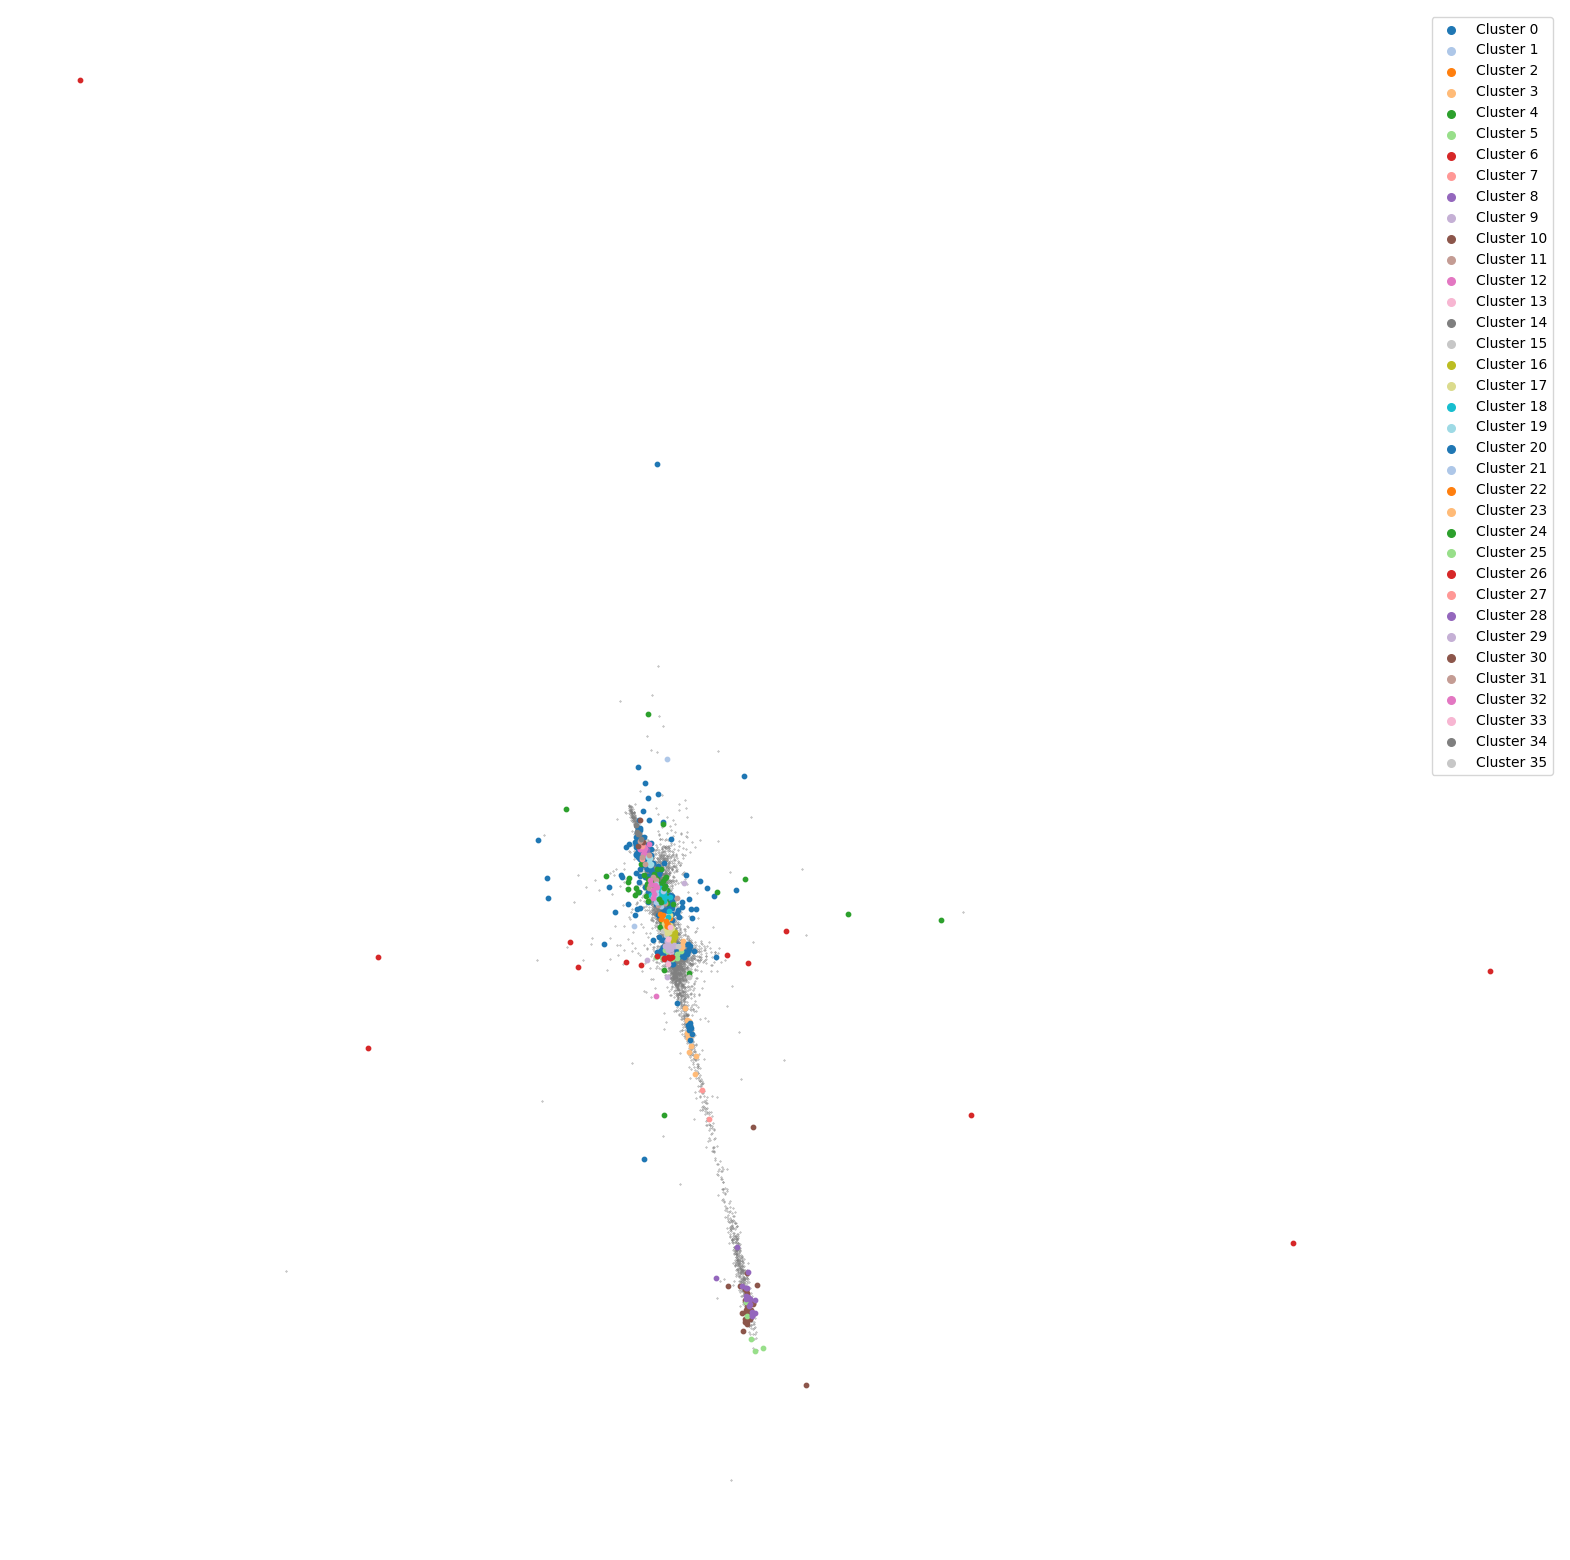

In [19]:
plot_dbscan_results(embeds, y, counts, min_size=MIN_SAMPLES)

The `plot_dbscan_results` function uses t-SNE to visualize DBScan results. Clusters are highlighted and outliers are in gray. 
The sampler will initialize using one random point per cluster.

We display below are a sample of the 10 biggest clusters :

In [20]:
for i, l in enumerate(np.argsort(counts)[::-1][:10]):
    l -= 1
    if l == -1:
        continue
        
    if counts[l + 1] <= MIN_SAMPLES:
        continue

    ids = np.where(y == l)[0]

    print("Cluster id :", l)
    print("Cluster size :", len(ids))
    display(df[['title', 'text']].iloc[ids].sample(5))  # min(5, len(ids))))

    print('-' * 100)

    # if i > 1:
    #     break

Cluster id : 0
Cluster size : 11717


,title,text
434735,Anatoly Savenko,"Anatoly Ivanovich Savenko (; 28 December 1874 in Pereiaslav, Poltava Governorate, Russian Empire – 1922 in Kerch, Russian SSR) was a Russian nationalist, social and political activist, lawyer, writer, essayist and journalist."
197324,Tałty,"Tałty () is a village in the administrative district of Gmina Mikołajki, within Mrągowo County, Warmian-Masurian Voivodeship, in northern Poland. It lies approximately north-west of Mikołajki, east of Mrągowo, and east of the regional capital Olsztyn."
485762,Starooskolsky District,"Starooskolsky District () is an administrative district (raion), one of the twenty-one in Belgorod Oblast, Russia. It is located in the north of the oblast. The area of the district is . Its administrative center is the city of Stary Oskol (which is not administratively a part of the district). Population: 35,063 (2002 Census);"
74486,Chess at the 2010 Asian Games – Women's team standard,The women's team standard competition at the 2010 Asian Games in Guangzhou was held from 18 November to 26 November at the Guangzhou Chess Institute.
57551,Igor Kozoš,Igor Kozoš (; born 4 August 1974) is a Serbian professional footballer who plays mainly as right defender for FK Bačka 1901.


----------------------------------------------------------------------------------------------------
Cluster id : 4
Cluster size : 2601


,title,text
217671,Wilfredo Rivera,"Wilfredo Rivera (born May 4, 1969) is a Puerto Rican former professional boxer who fought three times for world titles, losing to Pernell Whitaker twice and to Oscar De La Hoya."
139011,Luis Sánchez (Cuban footballer),Luis Manuel Sánchez Téllez (born 23 February 1952) is a Cuban footballer. He competed in the men's tournament at the 1980 Summer Olympics.
272767,Ignacio Ibáñez,Ignacio Elías Ibáñez Santana (born 8 October 1996) is a Chilean professional footballer who plays as a winger for Chilean Primera División side Unión Española.
1413,Olman Vargas,"Olman Andrés Vargas López (born April 15, 1985) is a Costa Rican footballer who currently plays for La U Universitarios."
215084,Tatito Hernández,"Rafael ""Tatito"" Hernández Montañez (born April 14, 1972) is a Puerto Rican politician affiliated with the Popular Democratic Party (PPD). He is also a Democrat. He has been a member of the Puerto Rico House of Representatives since 2009, representing District 11, which includes the town of Dorado and parts of the towns of Vega Alta and Vega Baja. In the 2020 elections he was re-elected and chosen as speaker of the house in 2021."


----------------------------------------------------------------------------------------------------
Cluster id : 10
Cluster size : 1610


,title,text
123430,Pseudocatharylla angolica,Pseudocatharylla angolica is a species of moth in the family Crambidae. It was described by Stanisław Błeszyński in 1964. It is found in Angola and South Africa.
194876,Teldenia nivea,Teldenia nivea is a moth in the family Drepanidae. It was described by Arthur Gardiner Butler in 1887. It is found on the Solomon Islands.
340909,Scopula quintaria,"Scopula quintaria is a moth of the family Geometridae, first described by Louis Beethoven Prout in 1916. It occurs in Malawi, South Africa and Príncipe."
325587,Hygroplasta spoliatella,Hygroplasta spoliatella is a moth in the family Lecithoceridae. It was described by Francis Walker in 1864. It is found in Sri Lanka.
117325,Udea accolalis,"Udea accolalis is a species of moth in the family Crambidae described by Philipp Christoph Zeller in 1867. It is found in France, Switzerland, Italy, Austria, the Czech Republic, Slovakia, Hungary, Poland, Romania, Ukraine, Belarus, the Baltic region, Finland, Sweden and Russia."


----------------------------------------------------------------------------------------------------
Cluster id : 28
Cluster size : 941


,title,text
143172,Hipponix conicus,"Hipponix conicus, common name the cone-shaped hoof shell, is a species of small limpet-like sea snail, a marine gastropod mollusk in the family Hipponicidae, the hoof snails."
312750,Brown-spotted nudibranch,"The brown-spotted nudibranch, currently known simply as ""Aphelodoris"" sp. 2, is an undescribed species of dorid nudibranch as designated by Zsilavecz, 2007. As at November 2009, it remains undescribed by science. It is a marine gastropod mollusc in the family Dorididae."
140142,Siphonalia pfefferi,"Siphonalia pfefferi, common name Pfeffer's whelk, is a species of sea snail, a marine gastropod mollusk in the family Buccinidae, the true whelks."
136035,Trochus chloromphalus,"Trochus chloromphalus is a species of small sea snail, a marine gastropod mollusc in the family Trochidae, the top snails."
134294,Austropeplea ollula,"Austropeplea ollula is a species of air-breathing freshwater snail, an aquatic pulmonate gastropod mollusk in the family Lymnaeidae, the pond snails."


----------------------------------------------------------------------------------------------------
Cluster id : 17
Cluster size : 837


,title,text
28730,KDKZ-LD,"KDKZ-LD, virtual and UHF digital channel 18, is a low-powered AMGTV-affiliated television station licensed to Farmington, Missouri, United States and serving the northwestern parts of the Cape Girardeau, Missouri/Paducah, Kentucky market, and the southernmost part of the St. Louis market."
316889,KBTG-LP,"KBTG-LP (99.5 FM) was a radio station licensed to Buffalo, Wyoming, United States. The station was owned by Buffalo Baptist Church. Citing staffing issues, the station fell silent on May 4, 2014."
320736,KRAW,"KRAW was a non-commercial radio station in Sterling, Alaska, broadcasting to the Kenai, Alaska, area on 90.1 FM. KRAW signed on as KWMD on July 26, 2003, programming a non-commercial modern rock format."
462556,WYFN,"WYFN (980 AM) is a radio station serving the Nashville, Tennessee area with a conservative religious radio format. It is a Bible Broadcasting Network (BBN) owned-and-operated station."
442435,WAKZ,"WAKZ (95.9 FM, ""Real 95.9"") is a radio station licensed to Sharpsville, Pennsylvania, and serving Youngstown, Ohio. The station is owned by iHeartMedia, Inc. The station airs a mainstream urban radio format. Prior to July 2, 2020, WAKZ broadcast a contemporary hit radio format as ""95.9 Kiss FM""."


----------------------------------------------------------------------------------------------------
Cluster id : 18
Cluster size : 734


,title,text
287520,2014 Essex County municipal elections,"Essex County, Ontario County Council Elections were held on October 27, 2014 in conjunction with municipal elections across the province."
177948,2000 Hart District Council election,"The 2000 Hart Council election took place on 4 May 2000 to elect members of Hart District Council in Hampshire, England. One third of the council was up for election and the council stayed under no overall control."
195257,2002 Peterborough City Council election,The 2002 Peterborough City Council election took place on 2 May 2002 to elect members of Peterborough City Council in England. This was on the same day as other local elections.
172567,2003 Chelmsford Borough Council election,The 2003 Chelmsford Borough Council election took place on 1 May 2003 to elect members of Chelmsford Borough Council in England. This was on the same day as other local elections.
172606,2002 Norwich City Council election,"The 2002 Norwich City Council election took place on 2 May 2002 to elect members of Norwich City Council in England. This was on the same day as other local elections. 16 of 48 seats (one-third) were up for election, with an additional seat up in Henderson ward due to a by-election."


----------------------------------------------------------------------------------------------------
Cluster id : 5
Cluster size : 681


,title,text
223679,Nara Line (JR West),"The is a commuter rail line in the Osaka–Kobe–Kyoto metropolitan area, operated by the West Japan Railway Company (JR West). Its official termini are Kizu Station in Kizugawa and Kyōto Station in Kyoto, within Kyoto Prefecture; however, all trains continue past Kizu on the Yamatoji Line (Kansai Main Line) to Nara Station in Nara, Nara Prefecture."
435183,Yokkaichi Station,"Yokkaichi Station is served by the Kansai Main Line, and is 37.2 rail kilometers from the terminus of the line at Nagoya Station. Trains on the Ise Railway Ise Line also terminate at this station, although the official terminal station for the line is at Kawarada Station."
46201,Mikawa-Ōno Station,"Mikawa-Ōno Station is served by the Iida Line, and is located 35.6 kilometers from the starting point of the line at Toyohashi Station."
113778,Minobu Line,"The is a railway line in the Tōkai region of Japan operated by the Central Japan Railway Company (JR Central). It connects Fuji Station in Fuji, Shizuoka to Kōfu Station in Kōfu, Yamanashi, and the Tōkaidō Main Line with the Chūō Main Line trunk railroads."
48454,Tomiyoshi Station,"Tomiyoshi Station is served by the Kintetsu Nagoya Line, and is located 12.1 kilometers from the terminus of the line at Kintetsu Nagoya Station."


----------------------------------------------------------------------------------------------------
Cluster id : 6
Cluster size : 557


,title,text
474353,"Kisakata, Akita","In 2003, the town had an estimated population of 12,836 and a density of 103.50 persons per km². The total area was 124.02 km²."
460159,Vallavilai,"As of 2011 India census Vallavilai had a population of 10282. Males constitute 51% of the population and Females 49%. Vallavilai has an average literacy rate of 86%, higher than the national average of 59.5%. Male literacy is 78% and female 75%. In Vallavilai 11% of the population is under 6 years of age."
89944,"Makubetsu, Hokkaido","As of September 2016, the town has an estimated population of 27,310 and a density of 80 persons per km. The total area is 340.46 km."
367022,"Dharampur, Dahanu","According to the 2011 census of India, Dharampur has 372 households. The effective literacy rate (i.e. the literacy rate of population excluding children aged 6 and below) is 27.28%."
456389,Therlam,"Therlam Mandal has a population of 59,338 in 2001. Males consists of 29,745 and females 29,593 of the population. The average literacy rate is 48%. Male literacy rate is 62% and that of females 34%."


----------------------------------------------------------------------------------------------------
Cluster id : 11
Cluster size : 503


,title,text
16971,Kim Bo-ra (politician),Kim Bo-ra (; born 8 September 1969) is a South Korean politician serving as Mayor of Anseong in Gyeonggi Province and its first woman mayor from April 2020.
50654,Lim Kwan-sik,Lim Kwan-Sik (; born 28 July 1975) is a South Korean retired footballer who played as a midfielder. He made his national team debut on 21 January 2000 at friendly against New Zealand.
470661,Lee Zi-on,Lee Zion (born 27 May 1996) is a South Korean table tennis player. Her highest career ITTF ranking was 70.
44568,Park Tae-hong,"Park Tae-Hong (; born March 25, 1991) is a South Korean football player who currently plays for K3 League side Busan Transportation Corporation FC."
149371,Lee Uk-jong,Lee Uk-jong (born 26 October 1966) is a South Korean athlete. He competed in the men's javelin throw at the 1988 Summer Olympics.


----------------------------------------------------------------------------------------------------


### Sampling

Apply the coreset algorithm, and show the results with t-SNE !

In [21]:
ids = coreset.sample(embeds)

Use previously computed dbscan_y
Initialize with 36 points


100%|██████████| 964/964 [00:04<00:00, 194.31it/s]


In [ ]:
plot_coreset_results(embeds, y, counts, ids, min_size=MIN_SAMPLES)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [17:10:31.022483] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


## Compare with Random Sampling

To assess performance of the sampler, we provide two metrics that aim at demonstrating that the sampled data is more diverse than what you would get using random sampling.
The run the algorithm several times for more robustness, and do not use any initialization to save time.

- **Diversity**: We count the number of topics the sampled data contains and normalize it by its size. A higher value is better. The provided BERTopic classifier takes 2374 different values on our data.
- **KL Divergence**: Using a 27-class domain classifier, we aim at having a uniform sampling. This is assessed using the Kullback-Leibler divergence of the distribution of the sampled classes from the uniform distribution. A lower value is better.

In [23]:
N_TEXTS = [100, 500, 1000, 2000, 3000, 4000, 5000]  # Number of texts to sample

In [24]:
len(df["bertopic_class"].unique())

2374

In [25]:
coreset = CoresetSampler(
    initialization="",
    dbscan_params={"eps": EPS, "min_samples": MIN_SAMPLES},
    tqdm_disable=True,
    verbose=0,
)

In [26]:
diversities_coreset = []
kl_divs_coreset = []
for n in N_TEXTS:
    diversities, kl_divs = [], []
    for _ in range(3):  # 3 -> 1 for faster execution
        sampled_ids = coreset.sample(embeds, n_samples=n)
        df_s = df.iloc[sampled_ids].reset_index(drop=True)
        
        # Diversity
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)

        # KL Div
        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_coreset.append(div)
    kl_divs_coreset.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  -  KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.990  -  KL Divergence 0.200
- n=500 	-  Diversity: 0.861  -  KL Divergence 0.294
- n=1000 	-  Diversity: 0.739  -  KL Divergence 0.280
- n=2000 	-  Diversity: 0.589  -  KL Divergence 0.303
- n=3000 	-  Diversity: 0.485  -  KL Divergence 0.300
- n=4000 	-  Diversity: 0.413  -  KL Divergence 0.315
- n=5000 	-  Diversity: 0.356  -  KL Divergence 0.316


In [27]:
diversities_random = []
kl_divs_random = []
for n in N_TEXTS:
    diversities = []
    kl_divs = []
    for _ in range(10):
        df_s = df.sample(n).reset_index(drop=True)
        
        # Diversity
        n_topics = len(df_s["bertopic_class"].unique())
        diversities.append(n_topics / n)
                
        # KL Div
        dist = df_s["domain"].value_counts().values / n
        unif = np.ones(len(dist)) / len(dist)
        kl_div = np.sum(dist * np.log(dist / unif))
        kl_divs.append(kl_div)

    div = np.mean(diversities)
    kl_div = np.mean(kl_divs)
    diversities_random.append(div)
    kl_divs_random.append(kl_div)
    print(f'- n={n} \t-  Diversity: {div:.3f}  - KL Divergence {kl_div :.3f}')

- n=100 	-  Diversity: 0.906  - KL Divergence 0.295
- n=500 	-  Diversity: 0.677  - KL Divergence 0.361
- n=1000 	-  Diversity: 0.543  - KL Divergence 0.409
- n=2000 	-  Diversity: 0.414  - KL Divergence 0.432
- n=3000 	-  Diversity: 0.339  - KL Divergence 0.428
- n=4000 	-  Diversity: 0.292  - KL Divergence 0.432
- n=5000 	-  Diversity: 0.259  - KL Divergence 0.453


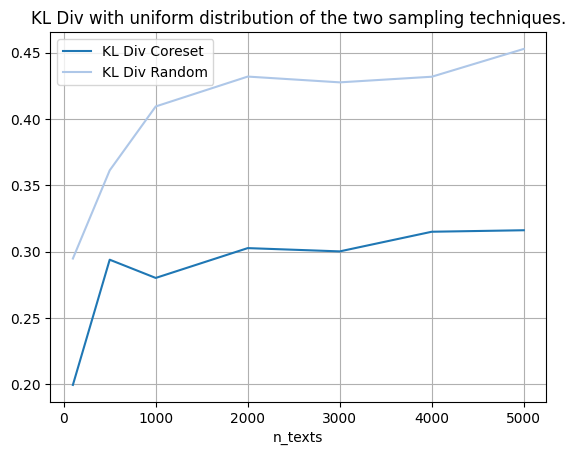

In [28]:
plt.plot(N_TEXTS, kl_divs_coreset, label="KL Div Coreset")
plt.plot(N_TEXTS, kl_divs_random, label="KL Div Random")
plt.xlabel('n_texts')
plt.legend()
# plt.ylim(0, 1)
plt.grid()
plt.title('KL Div with uniform distribution of the two sampling techniques.')
plt.show()

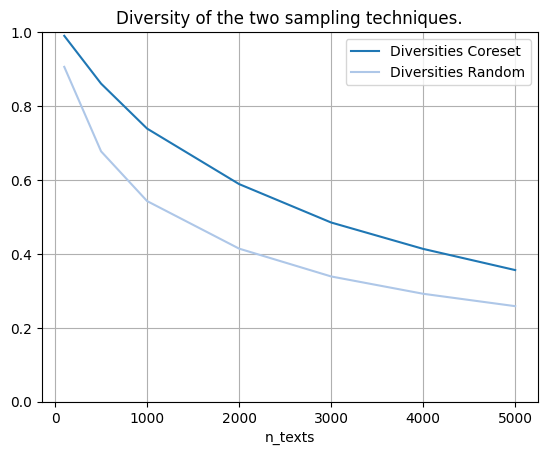

In [29]:
plt.plot(N_TEXTS, diversities_coreset, label="Diversities Coreset")
plt.plot(N_TEXTS, diversities_random, label="Diversities Random")
plt.xlabel('n_texts')
plt.legend()
plt.ylim(0, 1)
plt.grid()
plt.title('Diversity of the two sampling techniques.')
plt.show()

The metrics show that the sampled texts better captures the diversity of our dataset than random sampling, and are less biased by topic imbalance.

This is useful if your goal is to use a subset of wikipedia articles to finetune models.
A dataset sampled with coreset will provide more robustness for evaluation and more diversity of training.